# Detecting Kermit and Waldorf & Statler based on audio and visual features

This notebook documents our approach to detect Kermit and Waldorf and Statler based on feature-engineering for both modalities.  
We employ a Logistic Regression Classifier to predict the characters based on different video and audio-engineering features used for the different characters.

## Time sheet for this notebook

**Daniel Blasko:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>09.01.2024</td>
    <td>Setup notebook structure, load audio data and prepare the classifier - make the notebook ready so that only merging visual features is missing.</td>
    <td>3</td>
  </tr>
  <tr>
    <td>11.01.2024</td>
    <td>Work session together with Alina to integrate her features in the notebook.</td>
    <td>1</td>
  </tr>
</tbody>
</table>

**Alina Ehart:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>

  </tr>
</thead>
<tbody>
  
</tbody>
</table>


## Imports


In [ ]:
!pip install -r ../requirements.txt


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    accuracy_score,
)

import sys

sys.path.append("..")
from utils.visual_evaluation import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_global_confusion_matrix,
)


## Loading both sets of features and merging them into one dataframe


In each notebook for audio/vision, we have created a dataframe with the features fed into the classifier and exported it as a csv file. We will now load both csv files and merge them into one dataframe for the hybrid classifier.


In [14]:
audio_df = pd.read_csv("../results/sim1_audio/audio_features.csv")


In [15]:
vision_df = pd.read_csv("../results/sim1_audio/audio_features.csv")
# TODO: remove two following rows once we have the vision features, this is temporary to test the notebook
vision_df["StatlerWaldorf"] = audio_df["Audio_StatlerWaldorf"]
vision_df.drop(columns=["Audio_StatlerWaldorf"], inplace=True)


In [25]:
dataset = audio_df.merge(
    vision_df, on=["video_idx", "frame_idx", "Kermit"], how="inner"
)


Sanity check:


In [26]:
assert dataset.shape[0] == audio_df.shape[0] == vision_df.shape[0]
# TODO: check for _y and _x columns once vision dataset is available - should only be one Kermit column for example!!!


## Splitting the data and aggregating the labels


For the hybrid classifier, we want to detect if the character is present at a given frame whether it is through audio or visual features. Therefore, we will aggregate the labels for each frame by merging the visual and audio flags (when both are available, which is not the case for Kermit) into a single one.


In [27]:
dataset["StatlerWaldorf"] = (
    dataset["StatlerWaldorf"] + dataset["Audio_StatlerWaldorf"]
)  # TODO: test once we have data
dataset["StatlerWaldorf"].replace(2, 1, inplace=True)
dataset.drop(columns=["Audio_StatlerWaldorf"], inplace=True)


And then split our data and prepare it for the classifier:


In [28]:
RANDOM_SPLIT = True  # Change this boolean to experiment with one option or another


In [29]:
# We extract the `X` and `y` matrices for the model, and then split into train and test sets by a 80/20 ratio
X = dataset.drop(columns=["Kermit", "StatlerWaldorf", "video_idx", "frame_idx"])
y = dataset[["Kermit", "StatlerWaldorf"]]


In [30]:
if RANDOM_SPLIT:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.head(int(X.shape[0] * 0.8))
    X_test = X.tail(int(X.shape[0] * 0.2))
    y_train = y.head(int(y.shape[0] * 0.8))
    y_test = y.tail(int(y.shape[0] * 0.2))

assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]


Converting the one-hot-encoded labels into a single class column:  
Right now, the `y` matrix one-hot encodes the labels, but we need to convert it to a single column of labels for the classifier, where:

- 0: neither Kermit nor Waldorf & Statler are present
- 1: Kermit is present
- 2: Waldorf & Statler are present
- 3: both are present


In [31]:
# TODO: check y_train before to verify right ordering of cols!!!
y_train = np.argmax(y_train, axis=1) + np.any(y_train, axis=1)
y_test = np.argmax(y_test, axis=1) + np.any(y_test, axis=1)


## Training the classifier


For the hybrid classifier, we decide to use a logistic regression classifier that will take features from both modalities as an input. Its hyperparameters will be tuned through grid search and cross-validation.


In [ ]:
param_grid = {
    "penalty": ["l1", "l2", None],
    "C": [1, 0.7, 0.5, 0.3],
    "solver": ["saga"],  # TODO: if not scaled features, use lbfgs
    "multi_class": ["multinomial"],
    "max_iter": [200],
}
grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=3,
    scoring="recall_weighted",
)  # We optimize for recall because in experiments, false negatives were the biggest problem
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_
print(grid_search.best_params_)
y_pred = best_lr.predict(X_test)


## Evaluating the classifier


In [35]:
# Convert labels for the first character
y_test_kermit = (y_test == 1) | (y_test == 3)
y_pred_kermit = (y_pred == 1) | (y_pred == 3)

# Convert labels for the second character
y_test_wald_stat = (y_test == 2) | (y_test == 3)
y_pred_wald_stat = (y_pred == 2) | (y_pred == 3)


# Compute metrics for the first character
accuracy_kermit = accuracy_score(y_test_kermit, y_pred_kermit)
precision_kermit = precision_score(y_test_kermit, y_pred_kermit)
recall_kermit = recall_score(y_test_kermit, y_pred_kermit)
f1_kermit = f1_score(y_test_kermit, y_pred_kermit)
map_kermit = average_precision_score(y_test_kermit, y_pred_kermit)

# Compute metrics for the second character
accuracy_wald_stat = accuracy_score(y_test_wald_stat, y_pred_wald_stat)
precision_wald_stat = precision_score(y_test_wald_stat, y_pred_wald_stat)
recall_wald_stat = recall_score(y_test_wald_stat, y_pred_wald_stat)
f1_wald_stat = f1_score(y_test_wald_stat, y_pred_wald_stat)
map_wald_stat = average_precision_score(y_test_wald_stat, y_pred_wald_stat)

# Compute metrics for the general classifier as a whole
accuracy_general = accuracy_score(y_test, y_pred)
precision_general = precision_score(y_test, y_pred, average="weighted")
recall_general = recall_score(y_test, y_pred, average="weighted")
f1_general = f1_score(y_test, y_pred, average="weighted")


/Users/daniel/miniforge3/envs/simmod/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daniel/miniforge3/envs/simmod/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***General model metrics***
	Accuracy: 0.6984079043879708
	Precision: 0.6422985076680521
	Recall: 0.6984079043879708
	F1: 0.6106684622872514
***Kermit***
	Accuracy: 0.7191612374336627
	Precision: 0.5366515837104072
	Recall: 0.08998482549317147
	F1: 0.15412605588044184
	MAP: 0.30703839573246594
***Waldorf & Statler***
	Accuracy: 0.9774776718298313
	Precision: 0.0
	Recall: 0.0
	F1: 0.0
	MAP: 0.022522328170168703


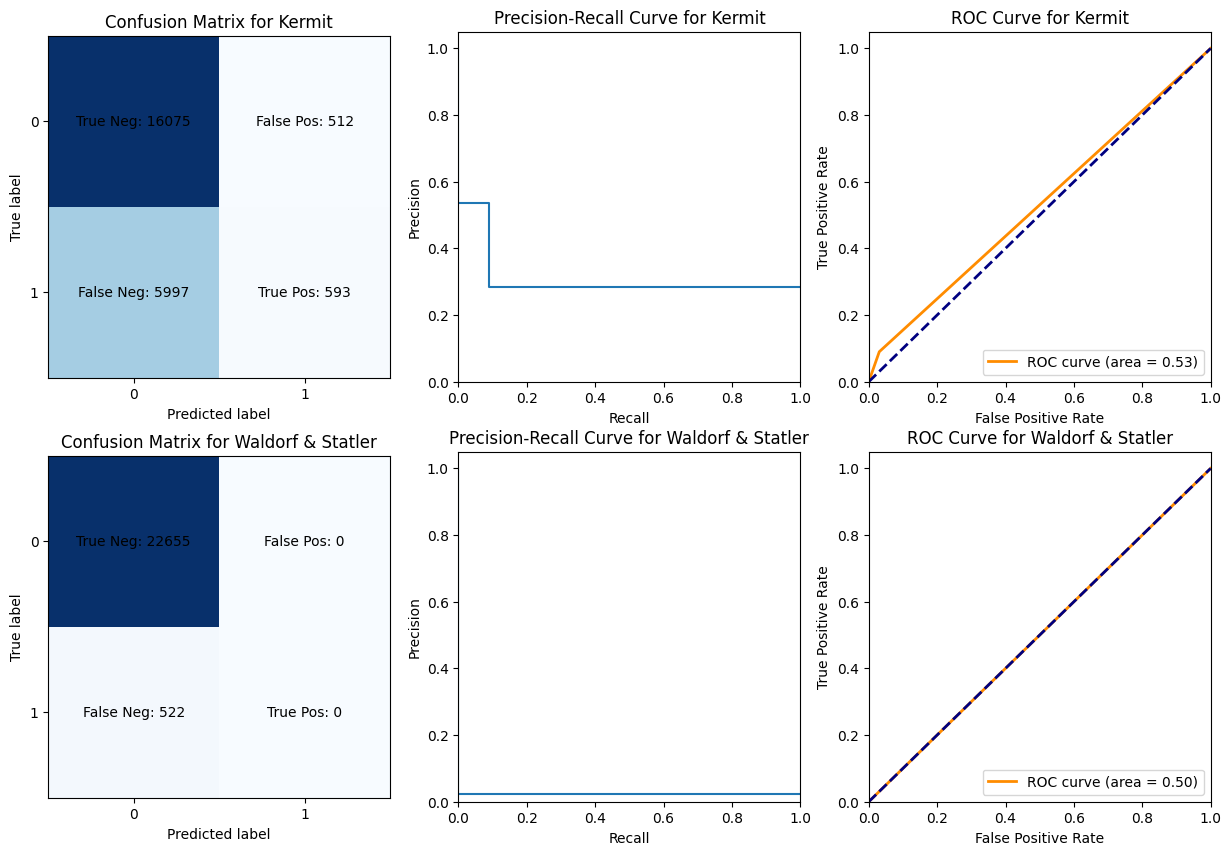

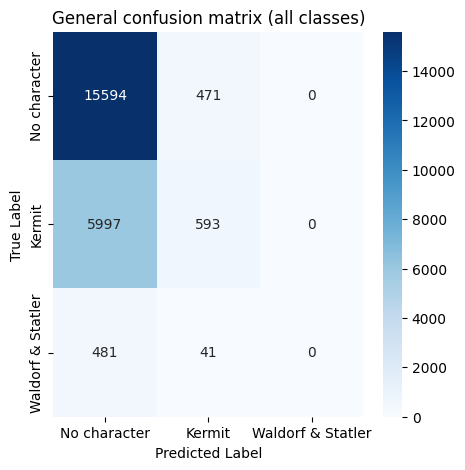

In [36]:
# *** Metrics ***
print(
    f"***General model metrics***\n\tAccuracy: {accuracy_general}\n\tPrecision: {precision_general}\n\tRecall: {recall_general}\n\tF1: {f1_general}"
)
print(
    f"***Kermit***\n\tAccuracy: {accuracy_kermit}\n\tPrecision: {precision_kermit}\n\tRecall: {recall_kermit}\n\tF1: {f1_kermit}\n\tMAP: {map_kermit}"
)
print(
    f"***Waldorf & Statler***\n\tAccuracy: {accuracy_wald_stat}\n\tPrecision: {precision_wald_stat}\n\tRecall: {recall_wald_stat}\n\tF1: {f1_wald_stat}\n\tMAP: {map_wald_stat}"
)

# *** Visual evaluation ***
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# Kermit
plot_confusion_matrix(
    y_test_kermit, y_pred_kermit, "Confusion Matrix for Kermit", ax=axs[0, 0]
)
plot_precision_recall_curve(
    y_test_kermit, y_pred_kermit, "Precision-Recall Curve for Kermit", ax=axs[0, 1]
)
plot_roc_curve(y_test_kermit, y_pred_kermit, "ROC Curve for Kermit", ax=axs[0, 2])
# Waldorf & Statler
plot_confusion_matrix(
    y_test_wald_stat,
    y_pred_wald_stat,
    "Confusion Matrix for Waldorf & Statler",
    ax=axs[1, 0],
)
plot_precision_recall_curve(
    y_test_wald_stat,
    y_pred_wald_stat,
    "Precision-Recall Curve for Waldorf & Statler",
    ax=axs[1, 1],
)
plot_roc_curve(
    y_test_wald_stat, y_pred_wald_stat, "ROC Curve for Waldorf & Statler", ax=axs[1, 2]
)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plot_global_confusion_matrix(
    y_test,
    y_pred,
    "Kermit",
    "Waldorf & Statler",
)


## Analysis of the results


TODO:
